In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from portfolio_functions import *
from sklearn.covariance import EmpiricalCovariance

In [2]:
#load dataframe
df = pd.read_csv("gp_data_1986_to_2015.csv")
    
#preview
df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,...,0.78,-1.11,0.85,3.80,4.61,1.91,5.60,2.48,1.67,-0.09
1,198602,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,...,7.47,2.71,8.34,9.98,8.68,10.61,7.03,8.85,7.21,9.27
2,198603,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,...,4.96,-0.11,0.04,-1.15,4.18,5.61,3.22,7.41,9.11,6.42
3,198604,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,...,3.33,3.87,3.55,2.69,-2.50,-0.93,-2.64,1.70,-0.70,3.86
4,198605,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,...,5.41,1.01,-0.75,2.51,6.66,5.07,0.70,5.52,11.95,4.89


## 1. Data Exploration and Analysis

First, we will reinforce the tools we have learned in the class and construct diversified portfolios among
the 43 industries.

### 1.1. Pre-processing

Calculate the excess return of the 43 industry portfolios. (Note that the excess return of the
market portfolio is already provided.) Subsequently, we will work with the excess returns directly
and treat the riskless rate as zero. Also, you may also treat each industry portfolio as an
individual asset.


In [3]:
#directly convert original monthly returns to excess returns; subtract rf from rf so risk-free rate is 0
df.iloc[:, 2:] = df.iloc[:, 2:].sub(df.iloc[:, 2], axis = 0)
df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.0,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
1,198602,7.13,0.0,13.45,7.36,11.15,7.18,11.67,10.19,7.75,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
2,198603,4.88,0.0,2.14,7.24,10.29,8.57,10.92,5.05,6.26,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
3,198604,-1.31,0.0,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
4,198605,4.62,0.0,0.59,8.06,7.46,5.88,9.67,2.67,5.42,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


### 1.2. Basic Portfolio Construction and In-sample analysis

1. Suppose you are asked to allocate your investment among the 43 industries. Use the 1986-2015
historical data, construct the following three portfolios:
<br>
• The equally weighted portfolio (EWP);
<br>
• The tangency portfolio (TAN);
<br>
• The global minimum variance portfolio (GMV).

In [4]:
#calculate expected return and covariance matrix
expected_rtn = estimate_mu(df.iloc[:, 3:])
cov_matrix = estimate_V(df.iloc[:, 3:])

#form portfolios
tangency_wt = tangency(expected_rtn, cov_matrix)
gmv_wt = gmv(cov_matrix)
ewp_wt = ewp(43)

2. Calculate the realized (in-sample) expected returns, standard deviations, Sharpe ratios, and
betas of every 43 industry portfolio, as well as the market portfolio (MKT), EWP, TAN, and
GMV.

In [5]:
#calculate monthly returns for each portfolio
df["Tangency"] = df.iloc[:, 3:46] @ tangency_wt
df["GMV"] = df.iloc[:, 3:46] @ gmv_wt
df["EWP"] = df.iloc[:, 3:46] @ ewp_wt

#dictionary of portfolio weights to be used later
wt = {
    "43": tangency_wt,
    "44": gmv_wt,
    "45": ewp_wt
}

output = {}

#calculate sigma for each asset (excl mkt)
for i in range(46):
    col = df.columns[i + 3]
    cov = EmpiricalCovariance().fit(df.iloc[:, [1, i + 3]]).covariance_
    beta = cov[0, 1]/cov[0,0]

    if i < 43:
        portfolio_wt = np.zeros(43)
        portfolio_wt[i] += 1
        perf_summary  = evaluate_portfolio_performance_on_data(portfolio_wt, df.iloc[:, 3:46])
    else:
        perf_summary = evaluate_portfolio_performance_on_data(wt[f"{i}"], df.iloc[:, 3:46])

    output[col] = [perf_summary['Er'], perf_summary['Sigma'], perf_summary['Sharpe'], beta]

#calculate stats for market portfolio
Er_mkt = df["Mkt-RF"].mean()
Sigma_mkt = df.iloc[:, 1].std(ddof = 0)
Sharpe_mkt = Er_mkt/Sigma_mkt
beta_mkt = 1
output["Mkt"] = [Er_mkt, Sigma_mkt, Sharpe_mkt, beta_mkt]

#output dataframe
output = pd.DataFrame.from_dict(output, orient = 'index', columns = ['Er', 'Sigma', 'Sharpe', 'Beta'])

Deliverable: In a 3 by 4 table, summarize the three in-sample performance metrics (i.e., expected return,
standard deviation, and Sharpe ratio) of the four portfolios (MKT, EWP, TAN, and GMV).

In [6]:
output.loc[["Mkt", "EWP", "Tangency", "GMV"],["Er", "Sigma", "Sharpe"]]

,Er,Sigma,Sharpe
Mkt,0.636361,4.478294,0.142099
EWP,0.718348,4.650387,0.154470
Tangency,1.916838,5.281517,0.362933
GMV,0.562142,2.860151,0.196543


Deliverable: Plot the following two graphs related to in-sample analysis:
<br>
(a) The σ vs. E[r] diagram. This diagram includes all of the 43 industry portfolios, the special
portfolios (i.e., EWP, TAN, and GMV) constructed from the 30-year data, the market
portfolio (MKT), and the in-sample efficient frontier.
<br>
(b) The β vs. E[r] diagram. This diagram includes the same set of portfolios (the 43 industry
portfolios treated as risky assets, MKT, EWP, TAN, and GMV) and a straight line that
represents the relationship between β and E[r] implied by CAPM (also known as the security
market line)

The in-sample tangency portfolio is:  [-0.051  0.158  0.058  0.143  0.26  -0.395  0.115 -0.252 -0.347 -0.033
 -0.028  0.301  0.248 -0.115  0.258  0.037  0.016 -0.064 -0.437 -0.08
  0.03   0.175  0.017 -0.163 -0.073  0.397 -0.053  0.358 -0.06   0.265
  0.32  -0.31  -0.444  0.436 -0.292  0.353  0.078  0.102  0.089  0.281
 -0.651  0.265  0.088]
The in-sample global minimum variance portfolio is:  [ 0.081  0.1   -0.005 -0.012 -0.042 -0.034 -0.026  0.044  0.211 -0.049
 -0.034  0.092 -0.023 -0.189 -0.067 -0.015 -0.047 -0.15  -0.074  0.071
 -0.007 -0.132 -0.039 -0.135 -0.032  0.116  0.057  0.028 -0.002  0.126
  0.385  0.097 -0.049 -0.06   0.098  0.023  0.002  0.123  0.07   0.212
  0.06   0.169  0.056]


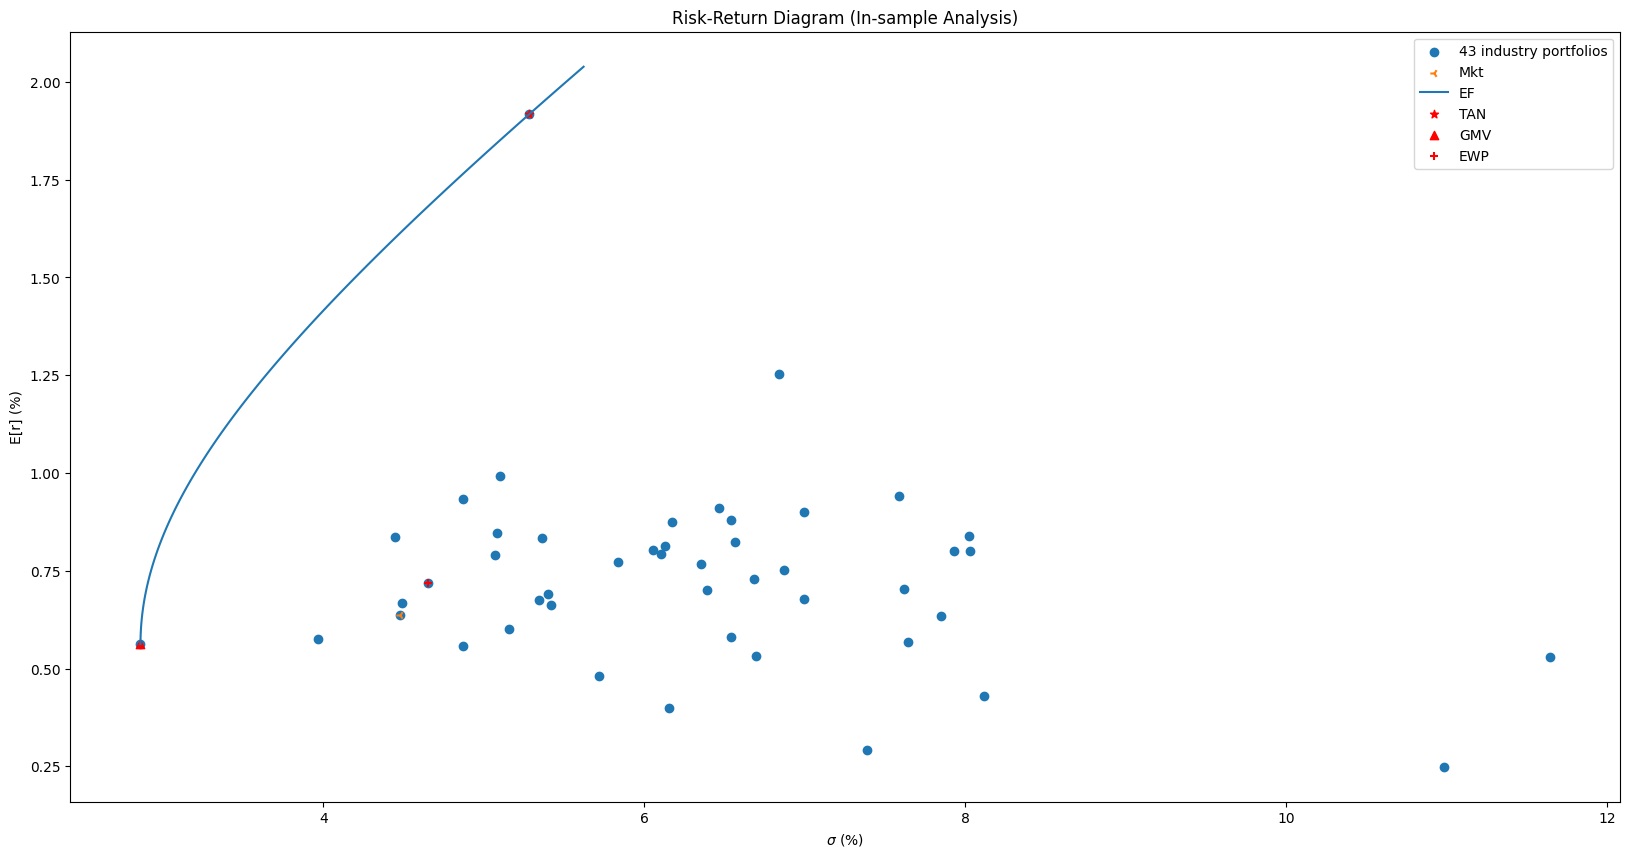

In [7]:
#a)
plt.figure(figsize=(20, 10))

#plot other 43 portfolios
portfolio_names = output.index
plt.scatter(output.iloc[:,1], output.iloc[:,0], label = "43 industry portfolios")
#plot market portfolio
plt.scatter(output.loc["Mkt", "Sigma"], output.loc["Mkt", "Er"], label = "Mkt", marker = "3")

#plot efficient frontier
plot_evaluation_results_in_sample(df.iloc[:, 3:46])



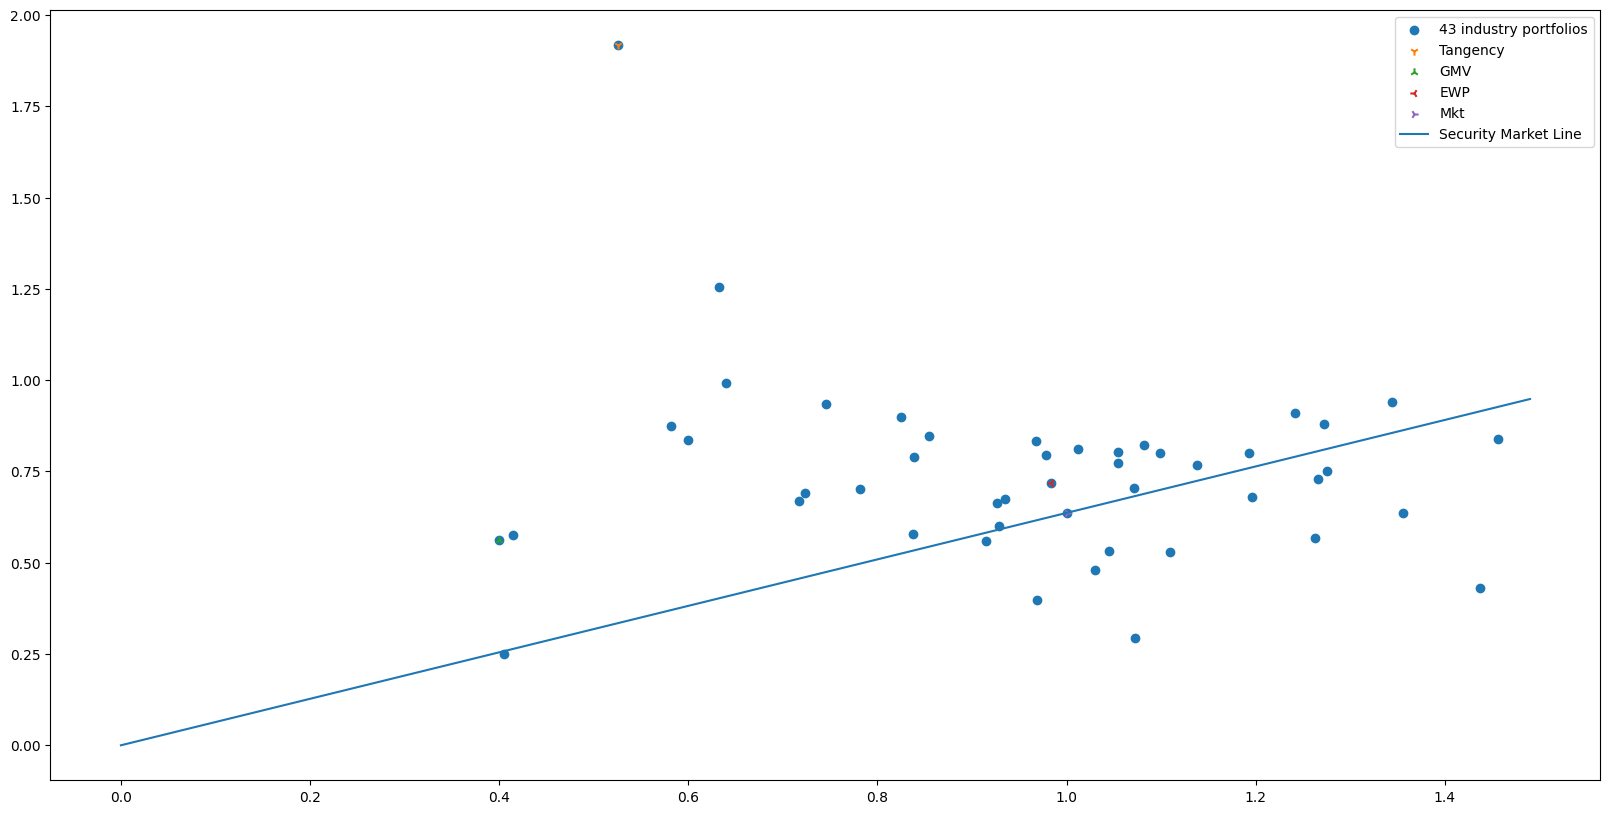

In [8]:
#b)
#calculate sml
beta_range = np.arange(0,1.5,0.01)
Er_range = beta_range * output.loc["Mkt", "Er"]

plt.figure(figsize = (20, 10))

#plot other 43 portfolios
plt.scatter(output.iloc[:,-1], output.iloc[:,0], label = "43 industry portfolios")

#plot other relevant portfolios
for i in range(43, 47):
    plt.scatter(output.iloc[i,-1], output.iloc[i,0], label = portfolio_names[i], marker = f"{i - 42}")

#plot SML
plt.plot(beta_range, Er_range, label = "Security Market Line")

plt.legend()

## 1.3.  Robust Portfolio Construction and Out-of-sample Analysis

In [9]:
#split into train and test
train = df.loc[df["Month"] <= 201012].drop(["GMV", "Tangency", "EWP"], axis = 1)
test = df.loc[df["Month"] >201012].drop(["GMV", "Tangency", "EWP"], axis = 1)

#function to calculate beta for each dataset, assuming market-risk free is in col 1 and other assets are in col 3 + i, 0 <= i <= 42
def get_beta(df):
    beta = []
    for i in range(43):
        covMatrix = EmpiricalCovariance().fit(train.iloc[:, [1, 3 + i]]).covariance_
        beta.append(covMatrix[0, 1]/covMatrix[0,0])

    return np.array(beta)

#function to plot efficient frontier
def plot_ef(wt_t, wt_gmv, V, mu, label):
    trange = np.arange(0,3,0.01)
    sigma_range = []
    er_range = []

    mu = mu.reshape(-1)

    for i in trange:
        wt_mix = i * wt_t + (1 - i) * wt_gmv
        var = wt_mix.T @ V @ wt_mix
        sigma_range.append(var ** 0.5)
        er_range.append(wt_mix.T @ mu)
    plt.plot(sigma_range, er_range, label = label)

 Estimating Beta. We will use the following shrinkage estimator of beta:
 <br>
βshrink = 0.5β¯ + 0.5β. ˆ
<br>
<br>
In the expression above, β¯ =
1
43
∑43
i=1 βˆ
i
is the grand average of beta across industries, βˆ is the
beta vector directly estimated from the sample covariance with MKT, and 0.5 is the shrinkage
constant that has been determined for you.


In [10]:
#calculate shrinked beta
beta_hat = get_beta(train)
beta_bar = np.mean(beta_hat)
shrinked_beta = 0.5 * beta_bar + 0.5 * beta_hat
shrinked_beta

array([0.85701587, 0.78554777, 0.91878221, 0.81845334, 0.80050887,
       1.0043332 , 1.1510755 , 0.99439164, 0.84918986, 1.04182083,
       0.89464713, 0.90973707, 0.85773813, 0.99398656, 1.01006935,
       1.07774378, 1.03878029, 1.07091068, 1.20400211, 1.00267582,
       1.1096002 , 1.10613155, 1.10933726, 0.99626296, 0.98560381,
       0.77305909, 0.69524505, 1.01189852, 1.02162797, 0.82121896,
       0.69609359, 0.95303175, 0.94852694, 1.13814019, 1.18307503,
       1.23344361, 1.13174117, 0.94301642, 0.96128002, 0.95229254,
       0.94161219, 0.98065442, 0.9131609 ])

Estimating Expected Return. Since estimating the expected return of an asset is a notoriously
difficult task, we will impose two layers of robustness in the estimation:
<br>
- First, we will use the CAPM-based expected return. That is the expected return implied
by CAPM that only depends on the value of beta.
<br>
- Second, we will use the robust estimation of beta itself; please see above

In [11]:
#calculate expected returns (qn: is this what's referred to as "robust estimation of beta"?)
capm_returns = shrinked_beta * train["Mkt-RF"].mean()
capm_returns

array([0.48118584, 0.44105889, 0.51586558, 0.45953427, 0.44945905,
       0.56389961, 0.64629052, 0.55831776, 0.4767918 , 0.58494767,
       0.50231454, 0.51078704, 0.48159137, 0.55809032, 0.56712027,
       0.6051172 , 0.58324051, 0.60128065, 0.67600705, 0.56296905,
       0.62300352, 0.62105599, 0.62285589, 0.55936844, 0.55338369,
       0.43404691, 0.39035692, 0.56814729, 0.57361005, 0.46108707,
       0.39083335, 0.53509556, 0.53256626, 0.63902778, 0.66425719,
       0.69253747, 0.63543494, 0.52947229, 0.53972669, 0.53468052,
       0.52868386, 0.55060477, 0.5127094 ])

Estimating covariance matrix. We will use the following shrinkage estimator of covariance matrix:
<br>
Vshrink = 0.3V
CC + 0.7V . ˆ
<br>
<br>
In the expression above, V
CC is the constant correlation matrix estimated from data, Vˆ is the
sample covariance matrix, and 0.3 is the shrinkage constant that has been determined for you.


In [12]:
#calculate Vhat
V_hat = train.iloc[:, 3:].cov()

#calculate average correlation
grand_avg_corr = 0
correlations = train.iloc[:, 3:].corr()
for i in range(43):
    grand_avg_corr += np.sum(correlations.iloc[i, i + 1:])
grand_avg_corr /= (43 * (43 - 1)) / 2

#calculate Vcc
Vcc = V_hat/correlations * grand_avg_corr

# convert the diagonal entires back into their original covariance
for i in range(43):
    Vcc.iloc[i,i] = V_hat.iat[i,i]

#calculate V_shrink
V_shrink = 0.3 * Vcc + 0.7 * V_hat
V_shrink.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
Agric,42.451075,12.777359,17.209770,14.250394,16.219475,18.914251,22.638322,18.296609,13.223025,20.850108,...,20.903907,21.584443,23.892899,22.037766,16.420213,18.782065,17.231559,16.281772,17.546442,16.058984
Food,12.777359,21.779965,17.443900,15.594761,18.491971,16.165161,17.568479,14.612466,13.324245,17.727510,...,13.496575,12.765217,13.542835,14.209125,13.929295,14.572044,13.161099,13.146036,14.960421,14.271160
Soda,17.209770,17.443900,55.908805,22.182191,20.202499,23.873275,29.542519,22.979945,19.239053,25.678783,...,21.233660,22.694546,25.323608,24.002609,21.703203,21.708653,20.390975,20.700827,20.286513,20.347367
Beer,14.250394,15.594761,22.182191,29.627435,17.614668,18.133782,19.659889,14.860450,16.521366,18.113976,...,15.614236,15.218682,16.755136,16.111384,16.074474,16.009318,15.115613,13.786886,16.046628,16.005152
Smoke,16.219475,18.491971,20.202499,17.614668,52.002929,19.335637,21.328569,16.091168,15.338208,19.056979,...,16.705665,17.801113,17.488624,18.884657,17.748387,18.127234,14.123070,17.852719,14.949859,15.885271


Second, with the robust estimation of parameters, we may construct the following robust version
of portfolios:
<br>
<br>
• TAN-robust: The tangency portfolio using Vshrink and µ
CAPM as problem inputs;
<br>
• GMV-robust: The global minimum variance portfolio using Vshrink as the problem input.
<br>
<br>
In other words, the (only) difference between TAN and TAN-robust is the input parameters (i.e.,
expected return and covariance matrix), and we do not disturb the mathematical optimization problem
itself. A similar thing can be said between GMV and GMV-robust

In [13]:
#er of testing set
er_train = train.iloc[:, 3:].mean()

#get tangency robust wt
wt_tan_robust_tr = np.linalg.inv(V_shrink) @ capm_returns
wt_tan_robust_tr /= np.sum(wt_tan_robust_tr)

#get gmv robust wt
wt_gmv_robust_tr = np.linalg.inv(V_shrink) @ np.ones(43)
wt_gmv_robust_tr /= np.sum(wt_gmv_robust_tr)

#get tangency wt
wt_tan_tr = np.linalg.inv(V_hat) @ er_train
wt_tan_tr /= np.sum(wt_tan_tr)

#get gmv wt
wt_gmv_tr = np.linalg.inv(V_hat) @ np.ones(43)
wt_gmv_tr /= np.sum(wt_gmv_tr)

#ewp wt
wt_ewp = np.ones(43)/43

Finally, we can compare the six different portfolio constructions (MKT, EWP, TAN, TAN-robust,
GMV, and GMV-robust) in an out-of-sample study. In this section, let us perform a simple version of the out-of-sample analysis. That is, we break
the data into two components:
<br>
<br>
• The training data correspond to the first 25 years, i.e., years 1986-2010.
<br>
• The test data correspond to the last 5 years, i.e., years 2011-2015.
<br>
<br>
In the out-of-sample analysis, we construct the portfolios from the training data but evaluate them
on the test data.

In [14]:
#er of testing set
er_test = test.iloc[:, 3:].mean()

#cov matrix of testing set
V_test = EmpiricalCovariance().fit(test.iloc[:, 3:]).covariance_

#get tangency wt
wt_tan_te = np.linalg.inv(V_test) @ er_test
wt_tan_te /= np.sum(wt_tan_te)

#get gmv wt
wt_gmv_te = np.linalg.inv(V_test) @ np.ones(43)
wt_gmv_te /= np.sum(wt_gmv_te)

Deliverable.
<br>
1. The out-of-sample σ vs. E[r] diagram. This diagram includes all of the 43 industry portfolios
(treated as risky assets), MKT, and the special portfolios constructed from training data (EWP,
TAN, GMV, TAN-robust, and GMV-robust). All of them are evaluated on the test data. Also,
please include the “true” and “realized” EF curves.


In [15]:
data_portfolios = {
    "gmv true": [wt_gmv_te @ er_test, (wt_gmv_te.T @ V_test @ wt_gmv_te) ** 0.5],
    "tan true": [wt_tan_te @ er_test, (wt_tan_te.T @ V_test @ wt_tan_te) ** 0.5],
    "gmv realized (non-robust)": [wt_gmv_tr @ er_test, (wt_gmv_tr.T @ V_test @ wt_gmv_tr) ** 0.5],
    "tan realized (non-robust)": [wt_tan_tr @ er_test, (wt_tan_tr.T @ V_test @ wt_tan_tr) ** 0.5],
    "gmv realized (robust)": [wt_gmv_robust_tr @ er_test, (wt_gmv_robust_tr.T @ V_test @ wt_gmv_robust_tr) ** 0.5],
    "tan realized (robust)": [wt_tan_robust_tr @ er_test, (wt_tan_robust_tr.T @ V_test @ wt_tan_robust_tr) ** 0.5],
    "EWP": [wt_ewp @ er_test, (wt_ewp.T @ V_test @ wt_ewp) ** 0.5],
    "MKT": [test.iloc[:, 1].mean(), test.iloc[:, 1].std()]
}

#add sharpe ratio
for k, v in data_portfolios.items():
    data_portfolios[k].append(v[0]/v[1])

data_industries = {
    "industries": test.columns,
    "Sigma": test.iloc[:, 3:].std(axis = 0),
    "Er": test.iloc[:, 3:].mean(axis = 0)
}

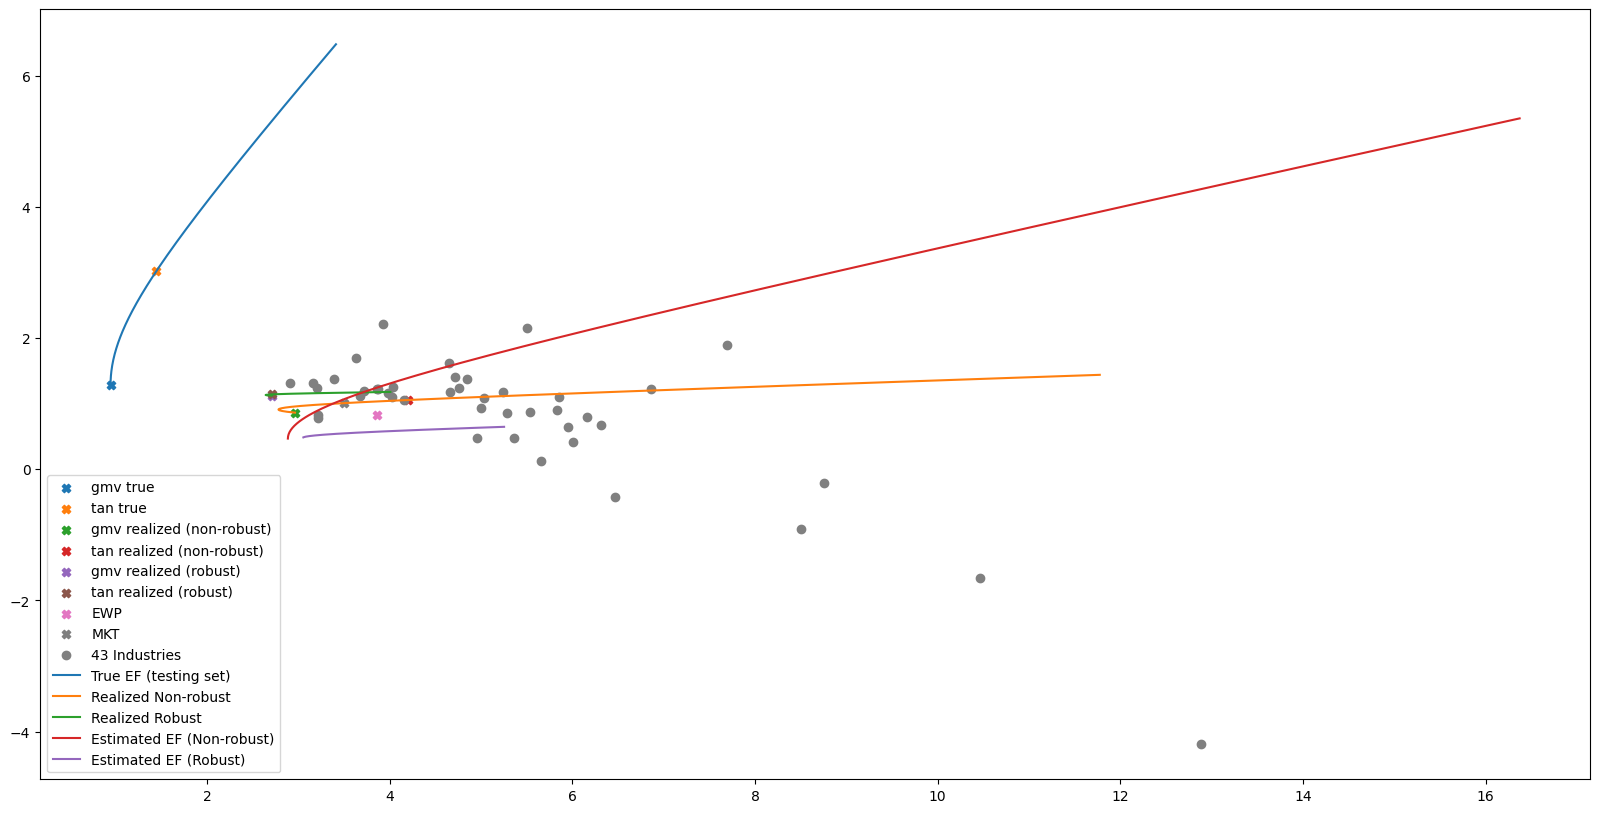

In [16]:
plt.figure(figsize = (20, 10))

#plot each pair of gmv and tan portfolios
for k, v in data_portfolios.items():
    plt.scatter(v[1], v[0], label = k, marker = "X")

#plot all assets
plt.scatter(data_industries["Sigma"], data_industries["Er"], label = "43 Industries", c = "grey")

#true ef - ef of tan and gmv portfolios constructed using the testing set itself
plot_ef(wt_tan_te, wt_gmv_te, V_test, er_test.values, label = "True EF (testing set)")

#realized non-robust - ef of tan and gmv portfolios constructed from training set but optimized using covariance and er of testing set
plot_ef(wt_tan_tr, wt_gmv_tr, V_test, er_test.values, label = "Realized Non-robust")

#realized robust - ef of tan and gmv portfolios constructed from training set with shrinkage parameters but optimized using covariance and er of testing set
plot_ef(wt_tan_robust_tr, wt_gmv_robust_tr, V_test, er_test.values, label = "Realized Robust")

#estimated ef using training data - non-robust
plot_ef(wt_tan_tr, wt_gmv_tr, V_hat, er_train.values, label = "Estimated EF (Non-robust)")

#estimated ef using training data - robust
plot_ef(wt_tan_robust_tr, wt_gmv_robust_tr, V_hat, er_train.values, label = "Estimated EF (Robust)")

plt.legend()

2. Compare the out-of-sample performances of MKT, EWP, TAN, TAN-robust, GMV, and GMVrobust using the definitions and methods introduced above. Report your results in a 3 by 6
table. (Recall that we have 3 performance metrics and 6 portfolios to compare.)


In [17]:
#Filter and generate a DataFrame
data_portfolios2 = {k: v for k, v in data_portfolios.items() if k in ["MKT", "EWP", "tan realized (non-robust)", "gmv realized (non-robust)", "tan realized (robust)", "gmv realized (robust)"]}
summary_table = pd.DataFrame.from_dict(data_portfolios2, orient='index', columns=["Er", "Sigma", "Sharpe"]).T
summary_table

,gmv realized (non-robust),tan realized (non-robust),gmv realized (robust),tan realized (robust),EWP,MKT
Er,0.863082,1.055857,1.122783,1.141517,0.822671,1.010833
Sigma,2.963800,4.201550,2.708489,2.712153,3.858277,3.502378
Sharpe,0.291208,0.251302,0.414542,0.420890,0.213222,0.288613


3. Contrast the table for out-of-sample performance with that for in-sample performance. What
are your findings and insights? Also, are there any limitations to the current evaluation methodology?


In [18]:
#in-sample performance
data_insample = {
    "in-sample gmv (non-robust)": [wt_gmv_tr @ er_train, (wt_gmv_tr.T @ V_hat @ wt_gmv_tr) ** 0.5],
    "in-sample tan (non-robust)": [wt_tan_tr @ er_train, (wt_tan_tr.T @ V_hat @ wt_tan_tr) ** 0.5],
    "in_sample gmv (robust)": [wt_gmv_robust_tr @ er_train, (wt_gmv_robust_tr.T @ V_hat @ wt_gmv_robust_tr) ** 0.5],
    "in-sample tan (robust)": [wt_tan_robust_tr @ er_train, (wt_tan_robust_tr.T @ V_hat @ wt_tan_robust_tr) ** 0.5],
    "EWP": [wt_ewp @ er_train, wt_ewp.T @ V_hat @ wt_ewp],
    "MKT": [train.iloc[:, 1].mean(), train.iloc[:, 1].std(),],
}

#calculate sharpe
for k, v in data_insample.items():
    data_insample[k].append(v[0]/v[1])

summary_table2 = pd.DataFrame.from_dict(data_insample, orient = 'index', columns = ["Er", "Sigma", "Sharpe"]).T
summary_table2

,in-sample gmv (non-robust),in-sample tan (non-robust),in_sample gmv (robust),in-sample tan (robust),EWP,MKT
Er,0.467903,2.100185,0.486128,0.539942,0.697483,0.561467
Sigma,2.885562,6.113378,3.055273,3.412344,23.048278,4.657505
Sharpe,0.162153,0.343539,0.159111,0.158232,0.030262,0.120551


Answer:
The non-robust Tangency portfolio has the best in-sample performance, with the highest Sharpe ratio of 0.343539. The non-robust Global Minimum Volatility (GMV) portfolio, designed to minimize variance, also has the lowest in-sample standard deviation. 

However, the out-of-sample results reveal a substantial discrepancy for both non-robust GMV and Tangency portfolios, with the latter experiencing a Sharpe ratio drop of approximately 30%. In contrast, the robust Tangency portfolio emerges as the standout performer in the out-of-sample period, boasting the highest Sharpe ratio of 0.420890. The robust GMV portfolio closely trails behind with a Sharpe ratio of 0.414542. This shift underscores the effectiveness of the shrinkage estimator framework in improving the generalization of in-sample data and enhancing the overall out-of-sample performance of the portfolios. 

However, I believe that this method of analysis is still lacking since we are only doing a single out-of-sample evaluation. Perhaps the results would be more consistent and telling on the impact of regularization if we were to repeat the evaluation multiple times, on a different testing set each time (in other words, cross-validation).

## 2. Data Challenge

In this section, we'll attempt to optimize the shrinkage parameter around several different variants of the covariance parameter estimates demonstrated in class, as well as some alternative methods and determine the most optimal approach to portfolio optimization

### 2.1 Optimizing shrinkage parameters for Constant Covariance Matrix Approach

Continuing from the previous section, we'll now try to find the optimal shrinkage parameter for Vshrink based on identity matrix, diagonal matrix, Vcc and empirical V - in descending degrees of generalization. To help us out, we also wrote several functions to automate certain processes.

1. generate_vshrink: This function takes any dataframe and a given shrinkage parameter, and generates Vshrink from them.
2. generate_folds: This function takes a dataframe and generates n folds with it. It outputs a nested list of indices for each fold.
3. cross_val: This function takes the dataframe, fold count as well as a shrinkage parameter, then passes it to the previous two functions to generate tangency and gmv portfolios. For each fold, it uses the training set to derive the gmv and tan weights, calculate the sharpe ratio of the realized gmv and tan portfolios and return them as two separate lists (one for each portfolio)
4. optimize_shrinkage: This function passes parameters to all of the preceding functions and makes use of skopt to optimize for the shrinkage parameter which maximizes sharpe ratio of the tangency portfolio.

In [19]:
#function to generate v_shrink
def generate_vshrink(df, sp, estimation_method = "cc"):
    #calculate Vhat
    V_hat = df.cov()

    if estimation_method == "cc":
        #calculate average correlation
        grand_avg_corr = 0
        correlations = df.corr()
        for i in range(len(df.columns)):
            grand_avg_corr += np.sum(correlations.iloc[i, i + 1:])
        grand_avg_corr /= (43 * (43 - 1)) / 2

        #calculate Vcc
        V_est = V_hat/correlations * grand_avg_corr

        # convert the diagonal entires back into their original covariance
        for i in range(len(df.columns)):
            V_est.iloc[i,i] = V_hat.iat[i,i]

    elif estimation_method == "diagonal":
        V_est = np.eye(len(df.columns)) * V_hat

    #calculate V_shrink
    if estimation_method == "identity":
        V_shrink = np.eye(len(df.columns))
    else:
        V_shrink = sp * V_est + (1 - sp) * V_hat

    return V_shrink
    
def generate_folds(df, n_folds, set_seed = True):
    fold_size = np.floor(len(df.index)/n_folds)
    indices = list(range(len(df.index)))
    folds = []
    
    if set_seed:
        np.random.seed(42)

    for i in range(n_folds):
        f = np.random.choice(indices, int(fold_size), replace = False, )
        folds.append(f)
        indices = [i for i in indices if i not in f]

    return folds

def cross_val(df, folds, sp, n_iter, portfolio_type, estimation_method = "cc", return_ls = False):
    sharpe_iter = []
    for r in range(n_iter):
        sharpe = []
        for i in folds:
            #validation set
            df_validate = df.iloc[i, 3:46]
            Er_validate = df_validate.mean()

            #training set
            df_train = df.iloc[~df.index.isin(i), 3:46]
            av_mkt_rtn_train = df.iloc[~df.index.isin(i), 1].mean()
            V_shrink = generate_vshrink(df_train, sp, estimation_method)

            beta_train = get_beta(df_train)
            beta_bar = np.mean(beta_train)
            beta_shrink = sp * beta_bar + (1 - sp) * beta_train
            Er_train = beta_shrink * av_mkt_rtn_train

            #calculate sharpe ratio
            if portfolio_type == "tan":
                train_tan = tangency(Er_train, V_shrink)
                sharpe_tan_realized = train_tan @ Er_validate / np.std(df_validate @ train_tan)
                sharpe.append(sharpe_tan_realized)
            elif portfolio_type == "gmv":
                train_gmv = gmv(V_shrink)
                sharpe_gmv_realized = train_gmv @ Er_validate / np.std(df_validate @ train_gmv)
                sharpe.append(sharpe_gmv_realized)

        #append mean sharpe of current iteration to sharpe_iter list
        sharpe_iter.append(np.mean(sharpe))

    if return_ls:
        #return the realized tangency portfolio's sharpe ratio for each fold
        return sharpe
    else:
        #return average sharpe ratio across all folds and iterations; only meaningful when set_seed is false for generate_folds
        return np.mean(sharpe_iter)

def objective_fn(sp, df = train, estimation_method = "cc", return_ls = False):
    sp = sp[0]
    #generate folds
    folds = generate_folds(df, 20)
    r = cross_val(df, folds, sp, 1, "tan", estimation_method = estimation_method, return_ls = return_ls)
    if return_ls:
        return r
    else:
        return -r

Here's a test run of our cross validation function for 20 shrinkage values; 20-fold cross validation of each shrinkage constant and the average for each shrinkage value is then plotted. 

From the graph below, we can see that the realized sharpe ratio for the tangency portfolio peaks with a shrinkage of approximately 0.8, indicating that this is the region where the optimal shrinkage occurs.

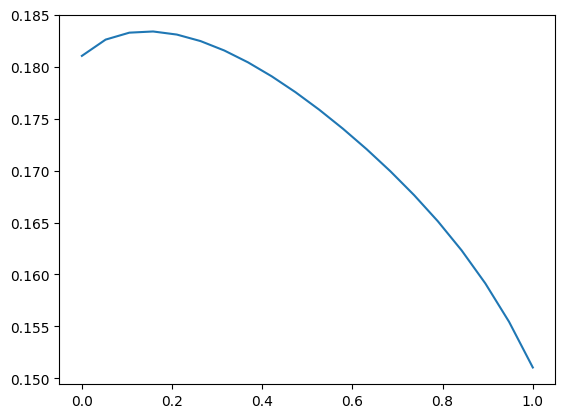

In [20]:
output_array = []

shrinkage_space = np.linspace(0, 1, 20)
for i in shrinkage_space:
    s = cross_val(train, generate_folds(train, 20), i, 1, "tan")
    output_array.append(s)

plt.plot(shrinkage_space, output_array)

We then employed scipy optimize's minimize function to get a better estimate of the optimal shrinkage value. As we can see from the results below, the optimum shrinkage for our constant covariance matrix method is 0.7467 (4 s.f).

In [21]:
from scipy.optimize import minimize

#set initial guess
w0 = [0.2]

#set bounds
bounds = [(0, 1)]

#optimize
r = minimize(
    objective_fn,
    w0,
    method = "SLSQP",
    bounds = bounds,
    options={'ftol': 1e-11, 'disp': True}
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.18340996905124105
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 6


In [22]:
#print optimal shrinkage value
r.x[0]

0.14431364133896196

We then repeated the same optimization process for the identity matrix and diagonal matrix methods of covariance estimation

In [23]:
#for identity matrix
r_identity = minimize(
    lambda w: objective_fn(w, estimation_method = "identity"),
    w0,
    method = "SLSQP",
    bounds = bounds,
    options={'ftol': 1e-11, 'disp': True}
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.19792038991612923
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 5


In [24]:
r_identity.x[0]

0.9999999999999998

In [25]:
#for diagonal matrix
r_diagonal = minimize(
    lambda w: objective_fn(w, estimation_method = "diagonal"),
    w0,
    method = "SLSQP",
    bounds = bounds,
    options={'ftol': 1e-11, 'disp': True}
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.22409612963021983
            Iterations: 7
            Function evaluations: 14
            Gradient evaluations: 7


In [26]:
r_diagonal.x[0]

0.684606118134318

### 2.2. In-sample Performance


In [27]:
cv_cc = objective_fn(r.x, return_ls = True)
cv_diagonal = objective_fn(r_diagonal.x, return_ls = True)
cv_identity = objective_fn(r_identity.x, return_ls = True)

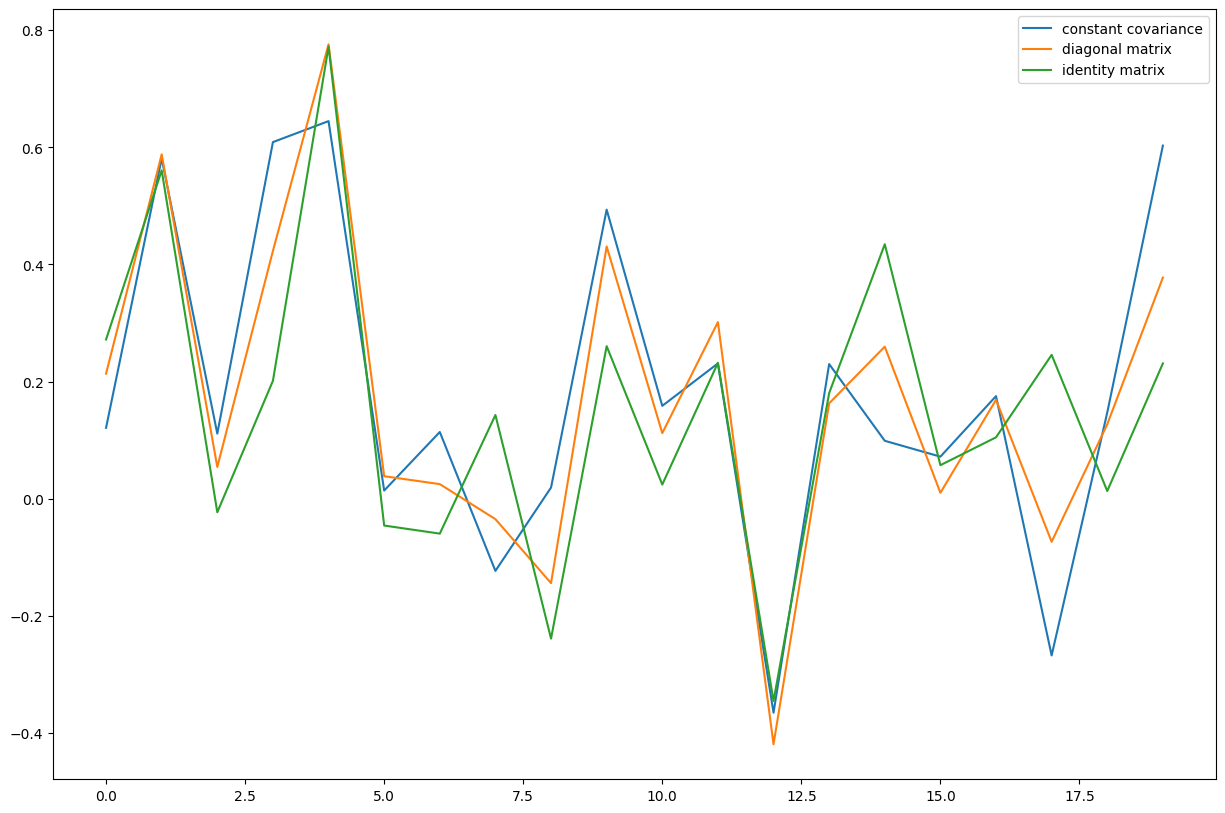

In [28]:
plt.figure(figsize = (15, 10))
plt.plot(cv_cc, label = "constant covariance")
plt.plot(cv_diagonal, label = "diagonal matrix")
plt.plot(cv_identity, label = "identity matrix")

plt.legend()

In [29]:
for i in ["cv_cc", "cv_diagonal", "cv_identity"]:
    v = eval(i)
    print(f"{i} - mean sharpe: {np.mean(v):.3f}, std sharpe: {np.std(v):.3f}")

cv_cc - mean sharpe: 0.183, std sharpe: 0.275
cv_diagonal - mean sharpe: 0.170, std sharpe: 0.262
cv_identity - mean sharpe: 0.151, std sharpe: 0.249


### 2.3. Out-of-sample Performance

In [30]:
#function to append results to summary table

def appendResults(summary, label, results):
    results = {label : results}
    metrics = pd.DataFrame.from_dict(results, orient = 'index', columns = ["Er", "Sigma", "Sharpe"]).T
    summary = pd.concat([summary, metrics], axis=1)
    return summary

    

In [31]:
#calculate Vhat
V_hat = train.iloc[:, 3:].cov()

#calculate average correlation
grand_avg_corr = 0
correlations = train.iloc[:, 3:].corr()
for i in range(43):
    grand_avg_corr += np.sum(correlations.iloc[i, i + 1:])
grand_avg_corr /= (43 * (43 - 1)) / 2

#calculate Vcc
Vcc = V_hat/correlations * grand_avg_corr

In [32]:
#constant covariance
Vshrink_cc = r.x[0] * V_hat + (1 - r.x[0]) * Vcc
tan_cc = np.linalg.inv(Vshrink_cc) @ er_test
tan_cc /= np.sum(tan_cc)
results = evaluate_portfolio_performance_on_data(tan_cc, test.iloc[:, 3:46])
print(results)

summary = appendResults(pd.DataFrame(), 'constant covariance', results)

{'Er': 11.545807359660305, 'Sigma': 16.751138978985335, 'var': 280.6006570932818, 'Sharpe': 0.6892550634404484}


In [33]:
#diagonal
Vshrink_diag = r_diagonal.x[0] * V_hat + (1 - r.x[0]) * V_hat * np.eye(len(V_hat.columns))
tan_diag = np.linalg.inv(Vshrink_diag) @ er_test
tan_diag /= np.sum(tan_diag)
results = evaluate_portfolio_performance_on_data(tan_diag, test.iloc[:, 3:46])
print(results)

summary = appendResults(summary, 'diagonal', results)

{'Er': 4.555517032065677, 'Sigma': 6.139984383455705, 'var': 37.69940822907993, 'Sharpe': 0.7419427717667487}


In [34]:
#identity
Vshrink_id = np.eye(len(V_hat.columns))
tan_id = np.linalg.inv(Vshrink_id) @ er_test
tan_id /= np.sum(tan_id)
results = evaluate_portfolio_performance_on_data(tan_id, test.iloc[:, 3:46])
print(results)

summary = appendResults(summary, 'identity', results)

{'Er': 2.166245094990632, 'Sigma': 3.7208640801017, 'var': 13.844829502591072, 'Sharpe': 0.5821887197049732}


### 2.4. Evaluation I

The in-sample tests highlight the constant correlation method as the superior estimator for the covariance matrix, producing a tangency portfolio with the highest Sharpe ratio. Across the 20-fold cross-validation process, all three methods exhibit similar degrees of variance in Sharpe ratios, with standard deviations of 0.249, 0.262, and 0.275.

Conversely, the diagonal matrix approach, utilizing a shrinkage constant of 0.685, proves most effective for out-of-sample performance, yielding the best Sharpe ratio despite a relatively low expected return of 4.56%. In comparison, the constant correlation matrix approach, while trailing the diagonal matrix approach by only 0.06 in terms of out-of-sample performance, presents a significantly higher expected return at 11.5%. However, this gain in expected return comes at the cost of a higher standard deviation (16.8%), nearly three times that of the diagonal matrix.

The choice of the preferred portfolio hinges on individual risk appetite. While the constant correlation approach offers a higher expected return, it also introduces greater volatility. Since we are more interested in beating the market, we believe that the constant correlation method is the most ideal.

In [35]:
summary

,constant covariance,diagonal,identity
Er,11.545807,4.555517,2.166245
Sigma,16.751139,6.139984,3.720864
Sharpe,0.689255,0.741943,0.582189


### 2.5. Using only most recent 10 years of Data

Next, we sought to further improve our approach to portfolio optimization. We hypothesized that using only recent data, as opposed to the entire dataset, would yield better portfolios. This is due to the dynamic nature of the market causing older data points to be less relevant in predicting future price movements. To do this, we picked the most recent 10 years of data, and dedicated 5 years of data to training and testing respectively. The goal here is to see if it improves the performance of our most ideal model (Vcc approach).

In [36]:
# total dataset will comprise 8years of training data + 2 years of test data
#data is given per month. to find the last 10 years, we take the last 120 observations
df_recent = pd.read_csv("gp_data_1986_to_2015.csv")
df_recent.iloc[:, 2:] = df_recent.iloc[:, 2:].sub(df_recent.iloc[:, 2], axis = 0)
df_recent = df_recent.iloc[-120:,:]

df_recent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 240 to 359
Data columns (total 46 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   120 non-null    int64  
 1   Mkt-RF  120 non-null    float64
 2   RF      120 non-null    float64
 3   Agric   120 non-null    float64
 4   Food    120 non-null    float64
 5   Soda    120 non-null    float64
 6   Beer    120 non-null    float64
 7   Smoke   120 non-null    float64
 8   Toys    120 non-null    float64
 9   Fun     120 non-null    float64
 10  Books   120 non-null    float64
 11  Hshld   120 non-null    float64
 12  Clths   120 non-null    float64
 13  Hlth    120 non-null    float64
 14  MedEq   120 non-null    float64
 15  Drugs   120 non-null    float64
 16  Chems   120 non-null    float64
 17  Rubbr   120 non-null    float64
 18  Txtls   120 non-null    float64
 19  BldMt   120 non-null    float64
 20  Cnstr   120 non-null    float64
 21  Steel   120 non-null    float64
 22  

In [37]:
#split into train and test
train_recent = df_recent.iloc[:96,:]
test_recent = df_recent.iloc[96:,:]

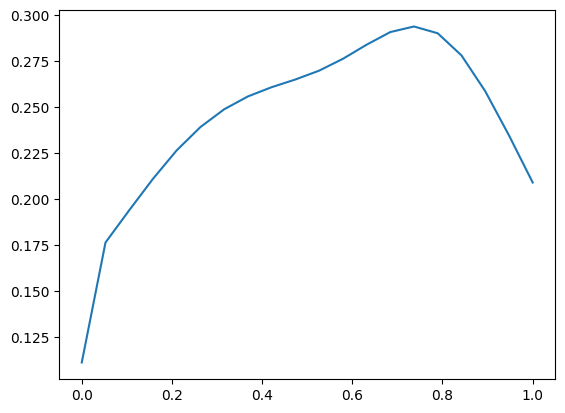

In [38]:
#getting a general sense of where the optimal shrinkage constant lies
output_array = []

shrinkage_space = np.linspace(0, 1, 20)
for i in shrinkage_space:
    s = cross_val(train_recent, generate_folds(train_recent, 20), i, 1, "tan")
    output_array.append(s)

plt.plot(shrinkage_space, output_array)

In [39]:
##optimize for shrinkage constant for Vcc

#set initial guess
w0 = [0.7]

#set bounds
bounds = [(0, 1)]

#optimize
r_5years = minimize(
    lambda w: objective_fn(w, df = train_recent),
    w0,
    method = "SLSQP",
    bounds = bounds,
    options={'ftol': 1e-11, 'disp': True}
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2938659484462683
            Iterations: 5
            Function evaluations: 11
            Gradient evaluations: 5


In [40]:
#Vcc's optimal shrinkage constant, using recent data
r_5years.x[0]

0.7374430527116628

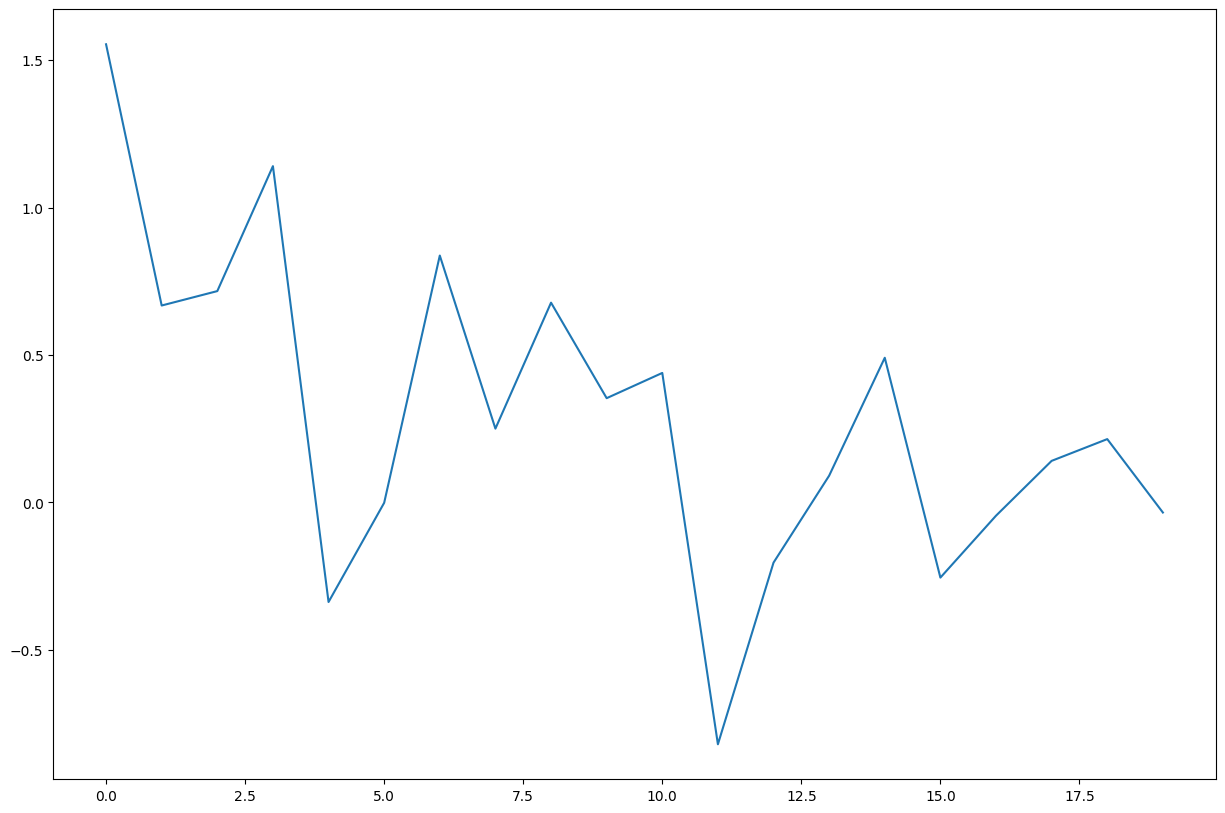

In [41]:
#visualizing the sharpe ratio of each fold across the 20-fold cross validation process for the optimal shrinkage constant found (in-sample performance analysis)
cv_cc = objective_fn(r_5years.x, df = train_recent, return_ls = True)
plt.figure(figsize = (15, 10))
plt.plot(cv_cc, label = "constant covariance")

In [42]:
#same as above, but in terms of mean and standard deviation of sharpe ratio across the 20 folds for the optimal shrinkage constant
v = eval('cv_cc')
print(f"{'cv_cc'} - mean sharpe: {np.mean(v):.3f}, std sharpe: {np.std(v):.3f}")

cv_cc - mean sharpe: 0.294, std sharpe: 0.534


In [43]:
#calculate Vhat
V_hat = train_recent.iloc[:, 3:].cov()

#calculate average correlation
grand_avg_corr = 0
correlations = train_recent.iloc[:, 3:].corr()
for i in range(43):
    grand_avg_corr += np.sum(correlations.iloc[i, i + 1:])
grand_avg_corr /= (43 * (43 - 1)) / 2

#calculate Vcc
Vcc = V_hat/correlations * grand_avg_corr

#er of testing set
er_test_recent = test_recent.iloc[:, 3:].mean()

#constant covariance
Vshrink_cc = r_5years.x[0] * V_hat + (1 - r_5years.x[0]) * Vcc
tan_cc = np.linalg.inv(Vshrink_cc) @ er_test_recent
tan_cc /= np.sum(tan_cc)
results = evaluate_portfolio_performance_on_data(tan_cc, test_recent.iloc[:, 3:46])

print(results)

summary = appendResults(summary, 'constant covariance (recent data)', results)

{'Er': 14.899181658116161, 'Sigma': 15.989972500730325, 'var': 255.679220574112, 'Sharpe': 0.9317828193535453}


### 2.6 Evaluation II

From the above results, we can see that the out-of-sample expected return of our new tangency portfolio increased significantly to 14.9%, while the standard deviation of return decreased from 16.8% to 16%. This led to a significant improvement in the sharpe ratio, from 0.689 to 0.931. In this regard, our hypothesis has been validated

In [44]:
summary

,constant covariance,diagonal,identity,constant covariance (recent data)
Er,11.545807,4.555517,2.166245,14.899182
Sigma,16.751139,6.139984,3.720864,15.989973
Sharpe,0.689255,0.741943,0.582189,0.931783


### 2.7. Other Portfolio Strategies (sortino maximizing, maximum diversification, EWP)

In [45]:
#with results from 2.5, try sortino maximizing, maximum diversification and EWP to see which portfolio strategy is the best

#maximum diversification
std_rtn_train = train_recent.iloc[:, 3:46].std()
w_maxdiv = np.linalg.inv(Vshrink_cc) @ std_rtn_train
w_maxdiv /= np.sum(w_maxdiv)

#evaluate performance
results = evaluate_portfolio_performance_on_data(w_maxdiv, test_recent.iloc[:, 3:46])

print(results)

summary = appendResults(summary, 'max diversification', results)

{'Er': -1.1742612836260842, 'Sigma': 5.860549953903003, 'var': 34.34604576219249, 'Sharpe': -0.20036708037000026}


In [46]:
#function to calculate negated sortino ratio
def get_sortino(wt, df):
    er = estimate_mu(df)
    downside_V = df[df < 0].cov()

    portfolio_rtn = wt @ er
    portfolio_downside_var = wt.T @ downside_V @ wt
    sortino = portfolio_rtn/portfolio_downside_var

    return -sortino

w0 = np.ones(43)/43

constraints = {
    'type': 'eq', 
    'fun': lambda w: np.sum(w) - 1
}

#set constraint on weight of each asset for numerical stability
wt_constraints = {'type': 'ineq', 'fun': lambda w: 1 - np.abs(w)}

#optimize for sortino-maximizing portfolio
r_sortino_max = minimize(
    lambda w: get_sortino(w, df = train_recent.iloc[:, 3:46]),
    w0,
    method = "SLSQP",
    constraints = [constraints, wt_constraints],
    options={'ftol': 1e-11, 'disp': True}
)

#evaluate performance of sortino-maximizing portfolio
results = evaluate_portfolio_performance_on_data(r_sortino_max.x, test_recent.iloc[:, 3:46])
print(results)

summary = appendResults(summary, 'sortino-maximising', results)

Iteration limit reached    (Exit mode 9)
            Current function value: -0.006905161728881595
            Iterations: 100
            Function evaluations: 4446
            Gradient evaluations: 100
{'Er': -11.422056647285723, 'Sigma': 27.324079889254246, 'var': 746.6053417943483, 'Sharpe': -0.41802163855397306}


In [47]:
#tangency with no-shorting constraint

#sharpe ratio fn
def get_sharpe(wt, df):
    er = estimate_mu(df)
    V = df.cov()

    portfolio_rtn = wt @ er
    portfolio_var = wt.T @ V @ wt
    sharpe = portfolio_rtn/portfolio_var

    return -sharpe

w0 = np.ones(43)/43

#weight constraint; sum of weights = 1
constraints = {
    'type': 'eq', 
    'fun': lambda w: np.sum(w) - 1
}

#no shorting constraint
bounds = [(0, None)] * len(w0)


r_sharpe_max = minimize(
    lambda w: get_sharpe(w, df = train_recent.iloc[:, 3:46]),
    w0,
    method = "SLSQP",
    bounds = bounds,
    constraints = [constraints],
    options={'ftol': 1e-11, 'disp': True}
)

results = evaluate_portfolio_performance_on_data(r_sharpe_max.x, test_recent.iloc[:, 3:46])
print(results)

summary = appendResults(summary, 'tan (no shorting)', results)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.09264198868087553
            Iterations: 26
            Function evaluations: 1145
            Gradient evaluations: 26
{'Er': 1.1943487357341156, 'Sigma': 2.9922619878484675, 'var': 8.953631803922862, 'Sharpe': 0.3991457768685859}


In [48]:
summary

,constant covariance,diagonal,identity,constant covariance (recent data),max diversification,sortino-maximising,tan (no shorting)
Er,11.545807,4.555517,2.166245,14.899182,-1.174261,-11.422057,1.194349
Sigma,16.751139,6.139984,3.720864,15.989973,5.860550,27.324080,2.992262
Sharpe,0.689255,0.741943,0.582189,0.931783,-0.200367,-0.418022,0.399146


### 3. Conclusion

In [50]:
pd.concat([summary_table2, summary], axis=1).T

,Er,Sigma,Sharpe
in-sample gmv (non-robust),0.467903,2.885562,0.162153
in-sample tan (non-robust),2.100185,6.113378,0.343539
in_sample gmv (robust),0.486128,3.055273,0.159111
in-sample tan (robust),0.539942,3.412344,0.158232
EWP,0.697483,23.048278,0.030262
MKT,0.561467,4.657505,0.120551
constant covariance,11.545807,16.751139,0.689255
diagonal,4.555517,6.139984,0.741943
identity,2.166245,3.720864,0.582189
constant covariance (recent data),14.899182,15.989973,0.931783
